In [1]:
import pandas as pd
import pyrsm as rsm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tuango = pd.read_pickle("data/tuango_post.pkl")

tuango.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278780 entries, 0 to 278779
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   userid      278780 non-null  object  
 1   recency     278780 non-null  int32   
 2   frequency   278780 non-null  int32   
 3   monetary    278780 non-null  float64 
 4   rfm_iq_pre  278780 non-null  object  
 5   buyer       278780 non-null  category
 6   ordersize   278780 non-null  float64 
 7   platform    278780 non-null  category
 8   category    278780 non-null  int32   
 9   mobile_os   278780 non-null  category
 10  training    278780 non-null  float64 
dtypes: category(3), float64(3), int32(3), object(2)
memory usage: 14.6+ MB


In [3]:
# 对推送有响应的顾客比例
np.mean(tuango.buyer=='yes')

0.02961474998206471

In [4]:
# 推送带来的平均订单金额
np.mean(tuango[tuango.buyer=='yes']['ordersize'])

202.4544573643411

In [5]:
# 划分独立 RFM 区间
# 其中 R最近购买时间，最近的一组标记为 1，F频率和 M金额都是最大的一组标记为 1
tuango = tuango.assign(rec_iq=rsm.xtile(tuango["recency"], 5))
tuango = tuango.assign(freq_iq=rsm.xtile(tuango["frequency"], 5, rev=True))
tuango = tuango.assign(mon_iq=rsm.xtile(tuango["monetary"], 5, rev=True))

In [14]:
# 生成独立 RFM 的三位号码
tuango = tuango.assign(
    rfm_iq=tuango["rec_iq"].astype(str)
    + tuango["freq_iq"].astype(str)
    + tuango["mon_iq"].astype(str)
)

In [15]:
# 顺序 RFM。按照 R，F，M 的顺序依次创建区间。

tuango = tuango.assign(
    freq_sq=tuango.groupby("rec_iq")["frequency"].transform(rsm.xtile, 5, rev=True)
)

tuango = tuango.assign(
    mon_sq=tuango.groupby(["rec_iq", "freq_sq"])["monetary"].transform(rsm.xtile, 5, rev=True)
)

# 生成顺序 RFM 的三位号码
tuango = tuango.assign(
    rfm_sq=tuango["rec_iq"].astype(str)
    + tuango["freq_sq"].astype(str)
    + tuango["mon_sq"].astype(str)
)

tuango.head()

,userid,recency,frequency,monetary,rfm_iq_pre,buyer,ordersize,platform,category,mobile_os,training,rec_iq,freq_iq,mon_iq,freq_sq,mon_sq,rfm_sq,rfm_iq
0,U12617430,309,7,39.8,514,no,0.0,App,3,android,1.0,5,1,4,1,4,514,514
1,U63302737,297,8,39.8,514,no,0.0,Browser,3,android,1.0,5,1,4,1,4,514,514
2,U77095928,295,1,72.9,553,no,0.0,Browser,3,android,1.0,5,5,3,5,3,553,553
3,U43509181,277,1,40.0,554,no,0.0,Browser,3,android,1.0,5,5,4,5,4,554,554
4,U23195941,259,1,21.0,555,no,0.0,App,3,android,1.0,5,5,5,5,5,555,555


In [16]:
tuango[tuango.rfm_iq_pre != tuango.rfm_iq]

,userid,recency,frequency,monetary,rfm_iq_pre,buyer,ordersize,platform,category,mobile_os,training,rec_iq,freq_iq,mon_iq,freq_sq,mon_sq,rfm_sq,rfm_iq


In [18]:
# 假设提供交易的边际成本为2.5元。每笔交易的费用为销售收入的50％。
# 202.13元 为推送带来的平均订单金额。那么需要响应率至少达到 0.024720656580638784 才能盈利。
breakeven = 2.5 / (202.13 - 101)
breakeven

0.024720656580638784

### 给所有用户发推送

In [19]:
def performance(df=tuango, mail_to=None, intro=None, perf='buyer', lev='yes'):
    df = df[df['training']==0]

    if mail_to:
        perc_mail = np.nanmean(df[mail_to]) # 推送比例
        df = df[df[mail_to]]
    else:
        perc_mail = 1.0 # 推送比例
        
    nr_mail = df.shape[0] # 推送数量
    mail_cost = 2.5 * nr_mail # 推送成本

    rep_rate = np.nanmean(df[perf]==lev) # 响应比例
    nr_resp = np.nansum(df[perf]==lev) # 响应数量

    revenue = df['ordersize'].sum()
    profit = 0.5 * revenue - mail_cost
    ROME = profit / mail_cost
    
    print(
    f"""推送数量及比例为 {int(nr_mail*perc_mail):,} ({round((100 * perc_mail), 2)}%) 名顾客
预计响应率为 {round((100 * rep_rate), 2)}%
预计收入为 ${int(revenue):,} ，预计成本为 ${int(mail_cost):,} 
预计利润为 ${int(profit):,}
营销费用回报率 ROME 为 {round((100 * ROME), 2)}%"""
)
    return [profit, ROME]

no_target = performance()

推送数量及比例为 250,902 (100.0%) 名顾客
预计响应率为 2.96%
预计收入为 $1,503,495 ，预计成本为 $627,255 
预计利润为 $124,492
营销费用回报率 ROME 为 19.85%


In [20]:
def response_rate(x, lev="yes"):
    return np.nanmean(x == lev)

def mailto(x, lev="yes", breakeven=0):
    return np.nanmean(x == "yes") > breakeven

breakeven = 2.5 / (202.13 - 101)

### 全局 breakeven rate

In [21]:
# calculate performance for independent RFM
tuango = tuango.assign(
    rfm_iq_resp=tuango.groupby("rfm_iq")["buyer"].transform(response_rate),
    mailto_iq=tuango.groupby("rfm_iq")["buyer"].transform(mailto, breakeven=breakeven)
)

RFM_iq = performance(df=tuango, mail_to='mailto_iq')

推送数量及比例为 43,235 (41.51%) 名顾客
预计响应率为 5.63%
预计收入为 $1,191,743 ，预计成本为 $260,382 
预计利润为 $335,489
营销费用回报率 ROME 为 128.84%


In [22]:
# calculate performance for sequential RFM
tuango['mailto_sq'] = tuango.groupby("rfm_sq")["buyer"].transform(mailto, breakeven=breakeven)

RFM_sq = performance(df=tuango, mail_to='mailto_sq')

推送数量及比例为 41,603 (40.72%) 名顾客
预计响应率为 5.76%
预计收入为 $1,196,258 ，预计成本为 $255,420 
预计利润为 $342,709
营销费用回报率 ROME 为 134.17%


### 分 cell 单独计算 breakeven rate

In [23]:
# 根据每个 RFM cell 计算单独的 breakeven rate
tuango["buyer_yes"] = np.where(tuango["buyer"] == "yes", 1, 0)
tuango['rfm_sq_resp']=tuango.groupby("rfm_sq")["buyer"].transform(response_rate)


tuango['avg_order_sq'] = tuango.groupby('rfm_sq')[['ordersize','buyer_yes']].transform(sum).apply(lambda x: x['ordersize']/x['buyer_yes'], axis=1).fillna(0)
tuango['breakeven_sq'] = (2.5 / (0.5*tuango['avg_order_sq']))

<ipython-input-23-5ca39610e075>:6: RuntimeWarning: invalid value encountered in double_scalars
  tuango['avg_order_sq'] = tuango.groupby('rfm_sq')[['ordersize','buyer_yes']].transform(sum).apply(lambda x: x['ordersize']/x['buyer_yes'], axis=1).fillna(0)


In [24]:
tuango['mailto_sq_pc'] = tuango['rfm_sq_resp'] > tuango['breakeven_sq']

tuango.mailto_sq_pc.sum()

RFM_sq_pc = performance(df=tuango, mail_to='mailto_sq_pc')

推送数量及比例为 42,004 (40.92%) 名顾客
预计响应率为 5.71%
预计收入为 $1,201,647 ，预计成本为 $256,650 
预计利润为 $344,173
营销费用回报率 ROME 为 134.1%


### 分 cell 单独计算 breakeven rate，考虑标准误

In [25]:
def prop_lb(x):
    prop = np.mean(x) - rsm.seprop(x)
    return rsm.ifelse(prop<0, 0, prop)

In [26]:
tuango['avg_order_iq'] = tuango.groupby('rfm_iq')[['ordersize','buyer_yes']].transform(sum).apply(lambda x: x['ordersize']/x['buyer_yes'], axis=1).fillna(0)
tuango['breakeven_iq'] = (2.5 / (0.5*tuango['avg_order_iq']))

tuango['mailto_iq_lb'] = (
    tuango.groupby('rfm_iq')['buyer_yes'].transform(prop_lb) > tuango.breakeven_iq
)

RFM_iq_lb = performance(df=tuango, mail_to='mailto_iq_lb')

<ipython-input-26-926f98b2fb99>:1: RuntimeWarning: invalid value encountered in double_scalars
  tuango['avg_order_iq'] = tuango.groupby('rfm_iq')[['ordersize','buyer_yes']].transform(sum).apply(lambda x: x['ordersize']/x['buyer_yes'], axis=1).fillna(0)


推送数量及比例为 34,129 (36.88%) 名顾客
预计响应率为 6.0%
预计收入为 $1,132,928 ，预计成本为 $231,342 
预计利润为 $335,121
营销费用回报率 ROME 为 144.86%


In [27]:
tuango['mailto_sq_lb'] = (
    tuango.groupby('rfm_sq')['buyer_yes'].transform(prop_lb) > tuango.breakeven_sq
)

RFM_sq_lb = performance(df=tuango, mail_to='mailto_sq_lb')

推送数量及比例为 34,080 (36.86%) 名顾客
预计响应率为 6.08%
预计收入为 $1,147,422 ，预计成本为 $231,177 
预计利润为 $342,533
营销费用回报率 ROME 为 148.17%


In [28]:
viz = pd.DataFrame(np.array([no_target,RFM_iq,RFM_sq,RFM_sq_pc,RFM_iq_lb,RFM_sq_lb]),columns=['profit','ROME'])
viz['n']=pd.Series(['no_target','RFM_iq','RFM_sq','RFM_sq_pc','RFM_iq_lb','RFM_sq_lb'])
viz

,profit,ROME,n
0,124492.5,0.198472,no_target
1,335489.0,1.288447,RFM_iq
2,342709.0,1.341747,RFM_sq
3,344173.5,1.341023,RFM_sq_pc
4,335121.5,1.448595,RFM_iq_lb
5,342533.5,1.481690,RFM_sq_lb


### Model Performance

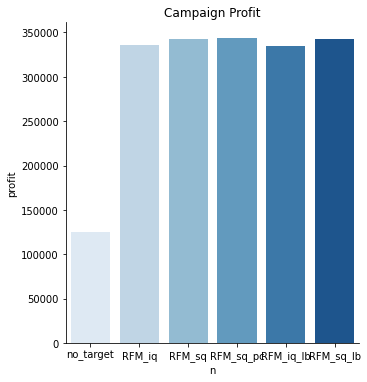

In [29]:
sns.catplot(x='n',y='profit',data=viz,kind='bar',palette="Blues").set(title='Campaign Profit')
plt.show()

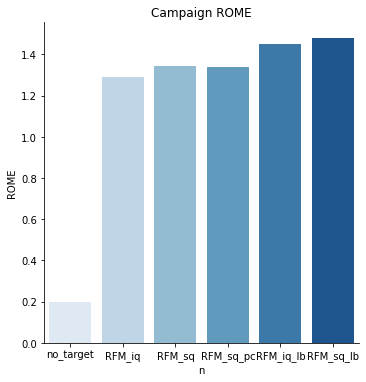

In [30]:
sns.catplot(x='n',y='ROME',data=viz,kind='bar',palette="Blues").set(title='Campaign ROME')
plt.show()